In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'
import helper

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

helper.download_extract('celeba', data_dir)

Found celeba Data


In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_img = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='RealInput')
    z = tf.placeholder(tf.float32, [None, z_dim], name='ZInput')
    lr = tf.placeholder(tf.float32, [], name='LearningRate')
    return real_img, z, lr

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        layer1 = tf.layers.conv2d(images, 64, 5, 2, 'same', use_bias=False)
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = tf.maximum(layer1*alpha, layer1)
        #14x14x64 now
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, 2, 'same', use_bias=False)
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(layer2*alpha, layer2)
        #7x7x128 now
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, 2, 'same', use_bias=False)
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(layer3*alpha, layer3)
        #4x4x256
        
        flatten = tf.reshape(layer3, [-1, 4*4*256])
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(is_train==False)):
        
        layer1 = tf.layers.dense(z, 4*4*512, use_bias=False)
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(layer1*alpha, layer1)
        layer1 = tf.reshape(layer1, [-1,4,4,512])
        #4x4x512 now
        
        layer2 = tf.image.resize_nearest_neighbor(layer1, [7,7])
        layer2 = tf.layers.conv2d(layer2, 256, 3, 1, 'same', use_bias=False)
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(layer2*alpha, layer2)
        #7x7x256 now
        
        layer3 = tf.image.resize_nearest_neighbor(layer2, [14,14])
        layer3 = tf.layers.conv2d(layer3, 128, 3, 1, 'same', use_bias=False)
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(layer3*alpha, layer3)
        #14x14x128 now
        
        #out layer, 28x28xout_dim
        layer4 = tf.image.resize_nearest_neighbor(layer3, [28,28])
        logits = tf.layers.conv2d(layer4, out_channel_dim, 3, 1, 'same', use_bias=False)
        out = tf.tanh(logits)
        return out
    
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True, alpha)
    d_model_real, d_model_logits_real = discriminator(input_real, False, alpha)
    d_model_fake, d_model_logits_fake = discriminator(g_model, True, alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_loss_fake, labels=tf.ones_like(d_loss_fake)))
    
    return d_loss, g_loss

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_img, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_img, z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    steps = 0
    time_stamp = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                _ = sess.run(d_opt, feed_dict={real_img:batch_images, z:batch_z})
                _ = sess.run(g_opt, feed_dict={real_img:batch_images, z:batch_z})
                
                if steps % 10 == 0:
                    time_cost = time.time() - time_stamp
                    time_stamp = time.time()
                    train_loss_d = sess.run(d_loss, feed_dict={real_img:batch_images, z:batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator loss: {:.4f}".format(train_loss_d),
                         "Generator loss: {:.4f}".format(train_loss_g),
                         "Speed: {:.4f}s per batch".format(time_cost/10))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:                 
                    show_generator_output(sess, 25, z, data_shape[-1], data_image_mode)
                    
            saver.save(sess, './checkpoints/generator.ckpt')
    return losses

Epoch 1/1... Discriminator loss: 1.0627 Generator loss: 0.4052 Speed: 6.3260s per batch


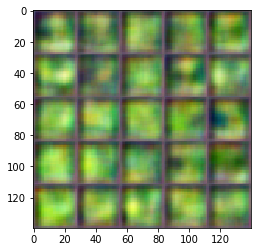

KeyboardInterrupt: 

In [6]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)